In [35]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import statsmodels.api as sm
from itertools import product

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [45]:
data = pd.read_csv('jj.csv', parse_dates=['date'])
data.head()

,date,data
0,1960-01-01,0.71
1,1960-01-04,0.63
2,1960-02-07,0.85
3,1960-01-10,0.44
4,1961-01-01,0.61


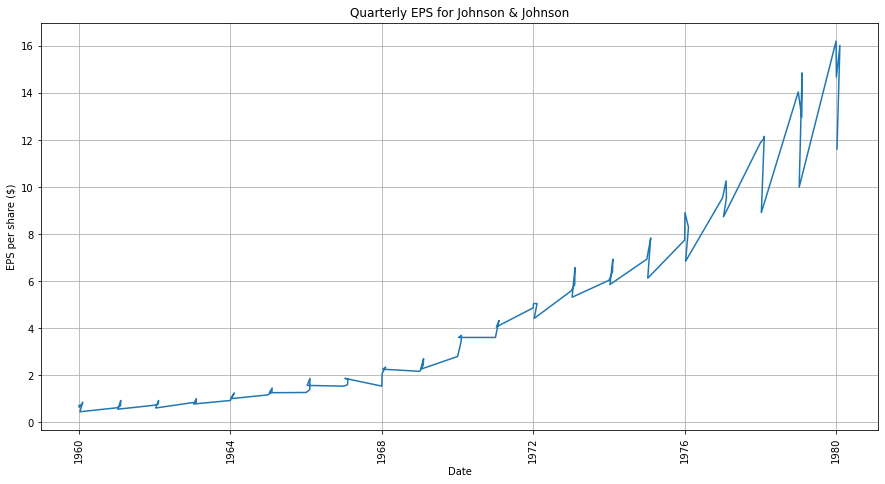

In [46]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['date'], data['data'])
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

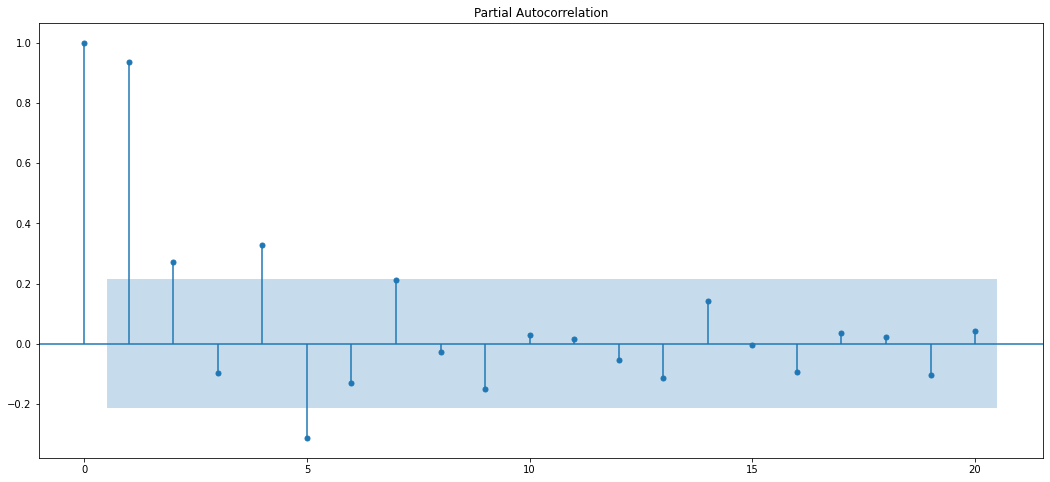

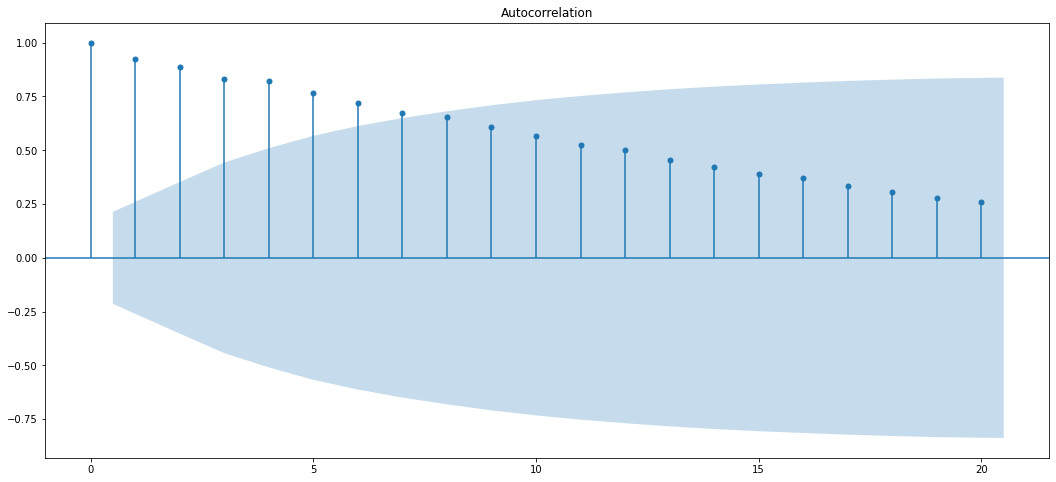

In [47]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [48]:
ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')



ADF Statistic: 2.7420165734574877
p-value: 1.0


In [49]:
from statsmodels.tsa.stattools import kpss
#define KPSS
# KPSS test is a statistical test to check for stationarity of a series around a deterministic trend.
# The word ‘deterministic’ implies the slope of the trend in the series does not change permanently. That is, even if the 
# series goes through a shock, it tends to regain its original path
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
      kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
kpss_test(data['data'])
# The p-value reported by the test is the probability score based on which you can decide whether to reject the null 
# hypothesis or not. If the p-value is less than a predefined alpha level (typically 0.05), we reject the null hypothesis.

Results of KPSS Test:
Test Statistic            0.706778
p-value                   0.012929
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [56]:
# Take the log difference to make data stationary

data['data'] = np.log(data['data'])
data['data'] = data['data'].diff()
data = data.drop(data.index[0])

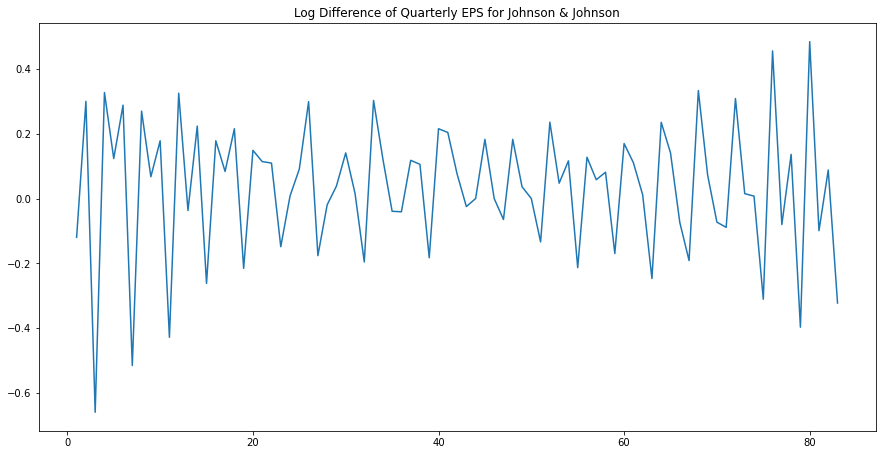

In [57]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [58]:
data['data'] = data['data'].diff(4)
data = data.drop([1, 2, 3, 4], axis=0).reset_index(drop=True)
data.head()

,date,data
0,-281059200000000000,0.242778
1,-280800000000000000,-0.011834
2,-283219200000000000,0.144006
3,-252460800000000000,-0.057351
4,-249523200000000000,-0.056093


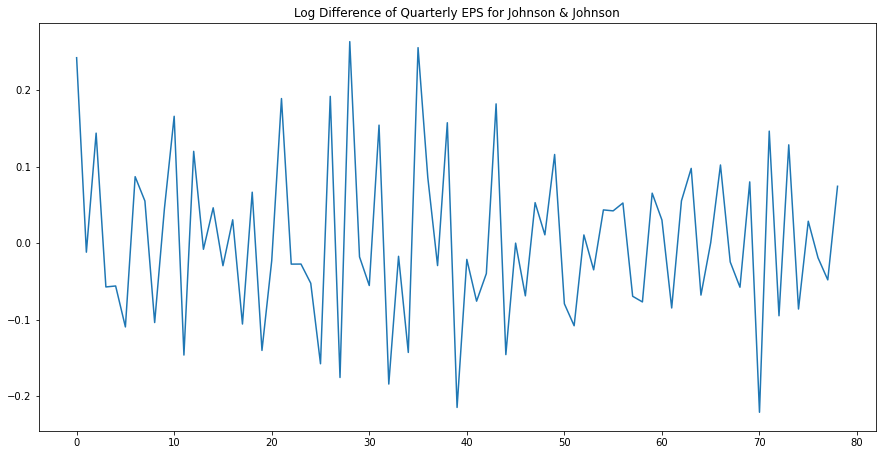

In [59]:
plt.figure(figsize=[15, 7.5]); # Set dimensions for figure
plt.plot(data['data'])
plt.title("Log Difference of Quarterly EPS for Johnson & Johnson")
plt.show()

In [60]:
# Augmented Dickey-Fuller test

ad_fuller_result = adfuller(data['data'])
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

# The p-value obtained should be less than the significance level (say 0.05) in order to reject the null hypothesis. 
# Thereby, inferring that the series is stationary.

ADF Statistic: -6.630805109914268
p-value: 5.721578695136043e-09


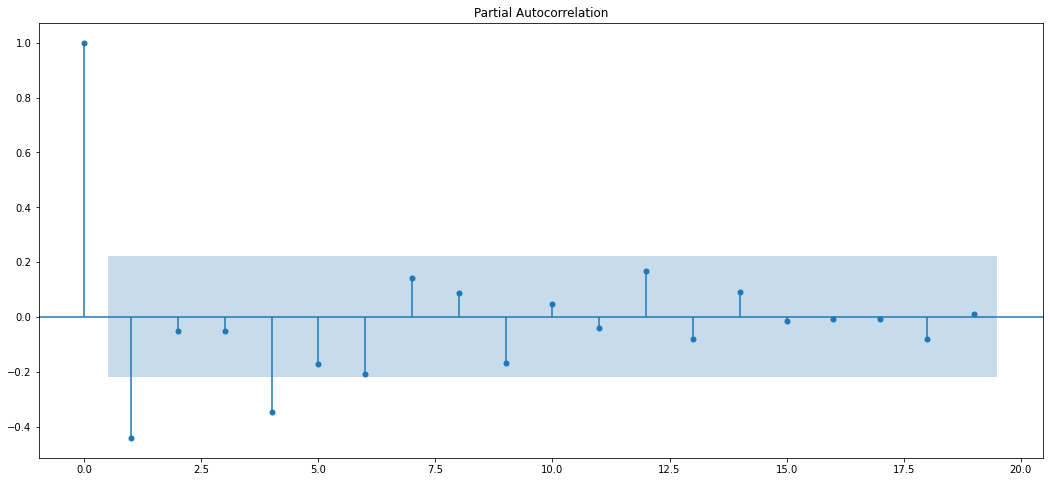

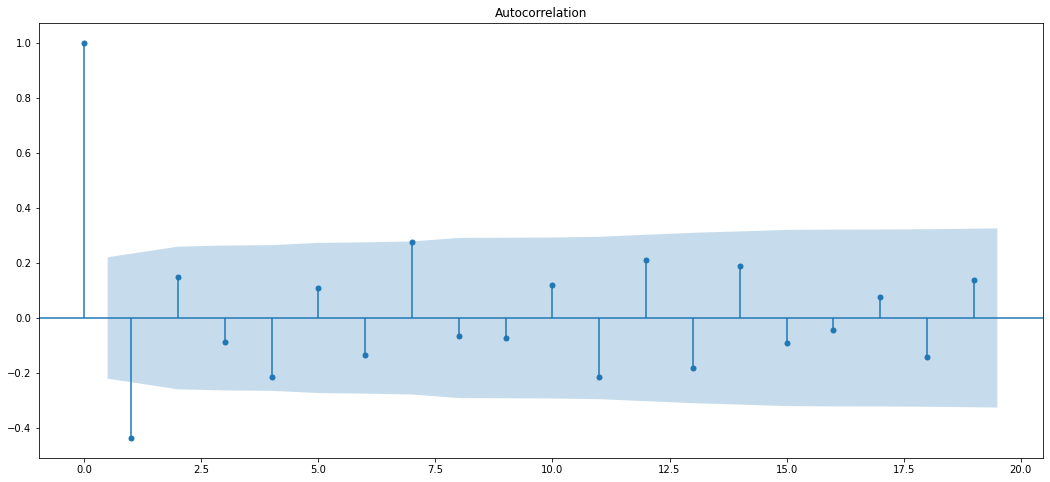

In [61]:
plot_pacf(data['data']);
plot_acf(data['data']);

In [62]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [63]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [64]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data['data'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 2, 0, 2)",-114.459832
1,"(0, 2, 1, 2)",-114.251528
2,"(0, 2, 1, 3)",-113.509777
3,"(0, 2, 2, 2)",-113.081086
4,"(0, 2, 0, 3)",-113.078605
...,...,...
251,"(0, 0, 1, 1)",-24.752956
252,"(0, 0, 0, 1)",-23.122474
253,"(1, 0, 0, 0)",-19.068827
254,"(0, 0, 1, 0)",2.594264


In [75]:
best_model = SARIMAX(data['data'], order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              data   No. Observations:                   84
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood                 -46.777
Date:                           Mon, 04 Jul 2022   AIC                            103.555
Time:                                   14:54:51   BIC                            115.402
Sample:                                        0   HQIC                           108.301
                                            - 84                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8617      0.112     -7.692      0.000      -1.081      -0.642
ma.L2          0.1191      0.134      0.889

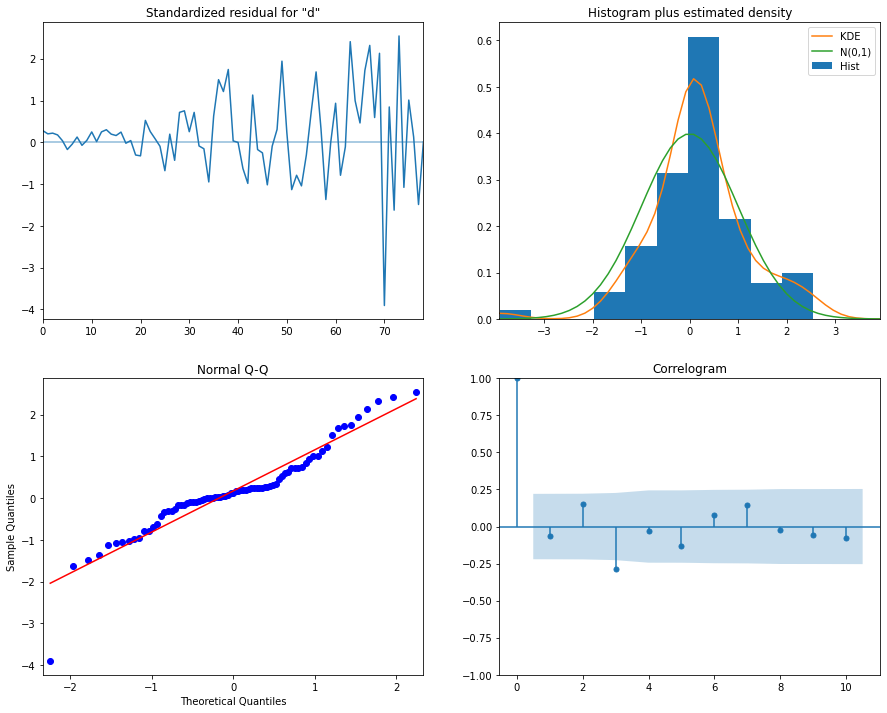

In [76]:
best_model.plot_diagnostics(figsize=(15,12));
# Points on the Normal QQ plot provide an indication of univariate normality of the dataset. If the data is normally 
# distributed, the points will fall on the 45-degree reference line. If the data is not normally distributed, the points 
# will deviate from the reference line.

# KDE kernel density estimation 
# In this method Kernel (continuous curve) is drawn at every individual data point and then all these curves are added 
# together to make a single smoothened density estimation. 

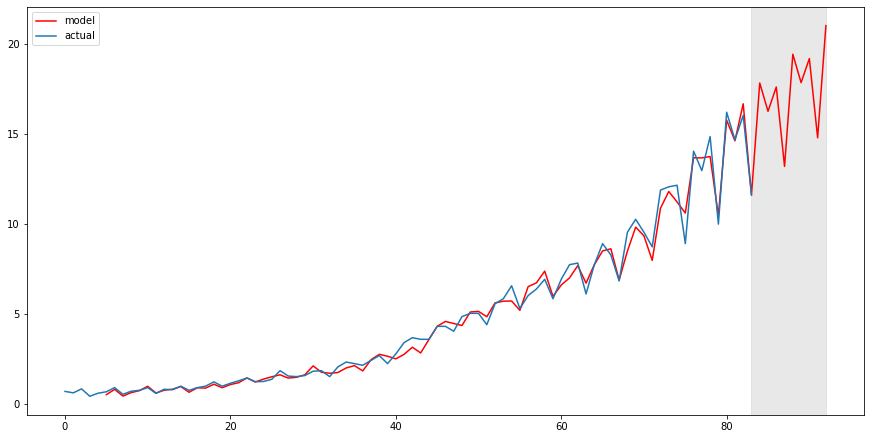

In [77]:
# From the normal Q-Q plot, we can see that we almost have a straight line, which suggest no systematic departure from 
# normality. Also, the correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and 
# so they are effectively white noise.

# We are ready to plot the predictions of our model and forecast into the future:

data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN

forecast = best_model.predict(start=data.shape[0], end=data.shape[0] + 8)
forecast = data['arima_model'].append(forecast)

plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data['data'], label='actual')
plt.legend()

plt.show()

In [78]:
data = pd.read_csv('jj.csv')
data.shape

(84, 2)

In [79]:
train, test = data.iloc[:75,:], data.iloc[75:,:]

In [80]:
model = ExponentialSmoothing(train['data'], seasonal='mul', seasonal_periods=4).fit()
pred = model.predict(start=test.index[0], end=test.index[-1])

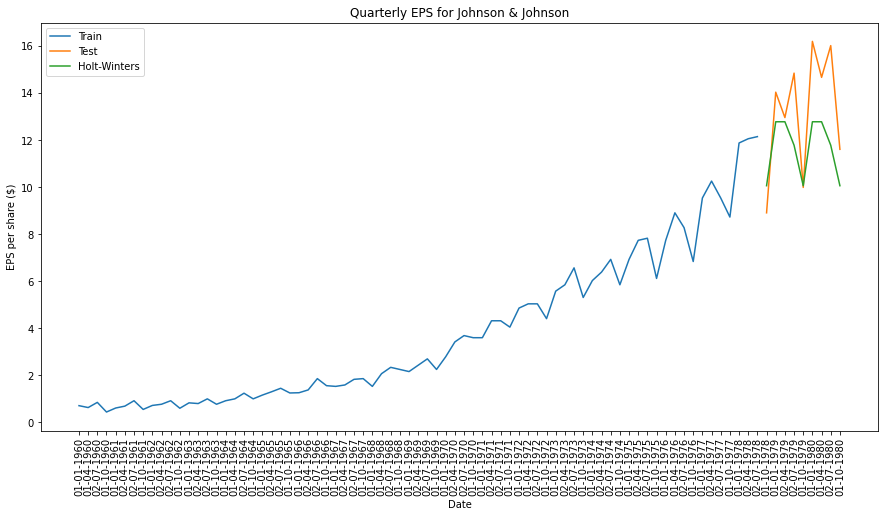

In [81]:
plt.figure(figsize=(15, 7.5))
plt.plot(train['date'], train['data'], label='Train')
plt.plot(test['date'], test['data'], label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.title('Quarterly EPS for Johnson & Johnson')
plt.ylabel('EPS per share ($)')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.legend()
plt.show()

In [82]:
y_forecasted = pred
y_truth = test['data']
mse = ((y_forecasted - y_truth) ** 2).mean()

#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

meanAbsPerErr = MAPE(   y_truth,y_forecasted )
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))
print('The mean absolute percentage error is {}'.format(round(meanAbsPerErr, 2)))

The Mean Squared Error is 5.33
The Root Mean Squared Error is 2.31
The mean absolute percentage error is 13.16
